This Jupyter notebook contains the code used to produce the figures in the paper "Characterizing the Multisectoral Impacts of Future Global Hydrologic Variability" by Birnbaum et al. currently under review.

Note: Figure 1 (schematic of stochastic watershed model procedure) was not made using code so is not included in the script.

* Figure 2: Determinic model (Xanthos) performance for Amazon, Indus, Mekong basins
* Figure 3: Compare relative bias, variance, correlation for determinic and stochsatic models
* Figure 4: Stochastic model performance in historical period for Amazon, Indus, Mekong basins
* Figure 5: Stochastic model performance in future period for Indus basin
* Figure 6: Variation in global/regional energy, agriculture, and water sectors
* Figure 7: Basin-scale relative variability in water sector
* Figure 8: Assessing multisector impacts of basin-scale extreme runoff (high and low) in Indus basin

# Import Statements

Begin by importing the following relavent Python libraries/packages

In [1]:
#load in self-defined functions in stochastic_error_model.py and HydroVar_functions.py
from stochastic_error_model import *
from HydroVar_functions import *

# general useful packages
import time, os, math, random
import pandas as pd # data analysis
import numpy as np # numerical analysis
import geopandas as gpd # spatial analysis

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm

# modeling packages (stats and machine learning)
import statsmodels.api as sm
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

And also set the color palette used for most of the figures

In [2]:
# set color palette
cpal = sns.color_palette('Paired',12)

# Load in data for Figures 1 - 5

Next, load in the data used to run the stochastic model and produce figures 1-5 that evaluate model performance

In [3]:
#set path to data
fpath = 'C:/Users/birnb/Documents/Tufts Research/GCIMS/birnbaum-etal_2024_HydroVariability/Data/'
histfile = 'Runoff_data/hist_annual.csv'
futfile = 'Runoff_data/fut_annual_gfdl_ssp370.csv'

#load in runoff data
df = pd.read_csv(fpath+histfile) #load in historical data
df_fut = pd.read_csv(fpath+futfile) #load in future data

#load in basin shapefiles
gcam_basins = gpd.read_file(fpath+'Shapefiles_for_mapping/gcam_basins.shp')
gcam_basins['basin_id'] = gcam_basins['sbRgnAl'].copy()

# Run Stochastic Model for 1000 simulations

In [4]:
m = 1000 # set number of stochastic realizations

Q = future_stoch_mvnorm(df,df_fut,m) #simulate stochastic realizations
Q[Q<0] = 0 # make sure there are no negative runoff values - set minimum to be zero for both historical and future

basin_nms = df.basin_name.unique() # get basin names
nbasins = len(basin_nms) # get # of basins
nyears = len(df['year'].unique()[:]) # get # of years

# get historical values
Q_hist = Q[:nyears,:,:]
q_ref = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_obs'].apply(lambda x:x).to_numpy(),
                       (nyears,nbasins),order='F')
q_det = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_det'].apply(lambda x:x).to_numpy(),
                   (nyears,nbasins),order='F')

# get future values
Q_fut = Q[nyears:,:,:]
nfyears = len(df_fut.year.unique()) #length 
df_fut['q_fut'] = df_fut['q_fut'].astype(float)
q_fut = np.reshape(df_fut.groupby(['basin_id'],group_keys=False)['q_fut'].apply(lambda x:x).to_numpy(),
                       (nfyears,nbasins),order='F')


# Plots for Figure 2

In [5]:
#calculate deterministic model NSE
nse_det = np.zeros([nbasins,2]) # create empty storage array for NSE

for i in range(nbasins): # loop through basins
    df_basin = df[df.basin_name==basin_nms[i]] 
    boi_obs = df_basin.q_obs.to_numpy() # observed runoff
    boi_det = df_basin.q_det.to_numpy() # deterministic model runoff
    nse_det[i,0] = df_basin['basin_id'].iloc[0] # first column is basin id
    nse_det[i,1] = calc_NSE(boi_obs,boi_det) #second column is NSE

nse_det = pd.DataFrame(nse_det,columns=['basin_id','nse_det']) #create dataframe
nse_det['basin_id'] = nse_det['basin_id'].astype(int) # make basin id integer type
nse_det = gcam_basins.merge(nse_det,on=['basin_id']) # merge with geopandas gcam_basins for plotting

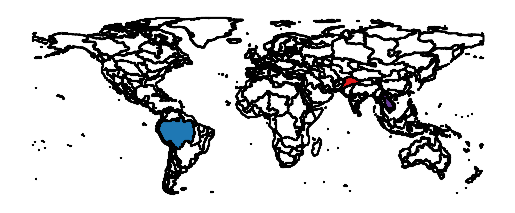

In [6]:
key_basins = ['Amazon','Indus','Mekong'] # select basins to highlight
 
df_key = df[df.basin_name.isin(key_basins)] # create dataframe of these key basins
key_ids = df_key.basin_id.unique() #get basin ids for these key basins

clist = [cpal[1],cpal[5],cpal[9]] # set colors for plotting

# plot map highlighting key basins
fig,ax = plt.subplots(1,1,)
gcam_key_basins = gcam_basins[gcam_basins.basin_id.isin(key_ids)]
gcam_key_basins = gcam_key_basins.sort_values(by='subRegn',ascending=True)
gcam_key_basins['c'] = clist
gcam_basins.boundary.plot(ax=ax,color='k')
gcam_key_basins.plot(ax=ax,color=gcam_key_basins['c'])
ax.set_axis_off()
plt.show()

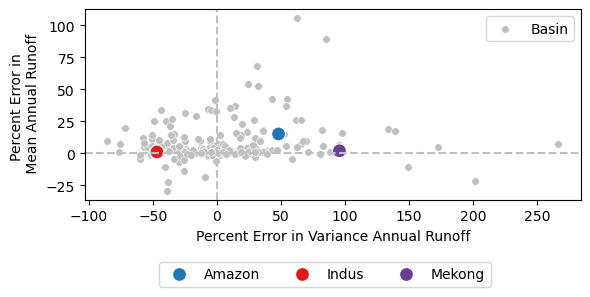

In [7]:
#calculate %error of mean and variance for all basins
df_err = df.copy() #copy dataframe 
df_mean = df_err.groupby(['basin_name','basin_id'])[['q_obs','q_det']].mean().reset_index() # get mean
df_std = df_err.groupby(['basin_name','basin_id'])[['q_obs','q_det']].std().reset_index() # get standard deviation
df_err = df_mean.merge(df_std,on=['basin_name','basin_id'],suffixes=['_mean','_std']) # merge dataframes
df_err['q_obs_cv'] = df_err['q_obs_std']/df_err['q_obs_mean'] # calculate coefficient of variantion of reference
df_err['q_det_cv'] = df_err['q_det_std']/df_err['q_det_mean'] # calculate coefficient of variation of deterministic
df_err['q_obs_var'] = df_err['q_obs_std']**2 # calculate variance of reference
df_err['q_det_var'] = df_err['q_det_std']**2 # calculate variance of determinsitic 
df_err['perr_mean'] = 100*((df_err.q_det_mean - df_err.q_obs_mean)/df_err.q_obs_mean) # % error of mean
df_err['perr_cv'] = 100*((df_err.q_det_cv - df_err.q_obs_cv)/df_err.q_obs_cv) # % error of CV
df_err['perr_var'] = 100*((df_err.q_det_var - df_err.q_obs_var)/df_err.q_obs_var) # % error of variance
df_err_key = df_err[df_err.basin_name.isin(key_basins)] # now isolate just key basins

#plot percent error mean versus percent error variance
fig,ax = plt.subplots(1,1) #initialize plot
plt.axhline(0,color='silver',ls='--') # horizontal line at zero (ideal)
plt.axvline(0,color='silver',ls='--') # vertical line at zero (ideal)
sns.scatterplot(data=df_err,y='perr_mean',x='perr_var',color='silver',s=30,label='Basin') # plot all basins
ax.legend(title='')
sns.scatterplot(data=df_err_key,y='perr_mean',x='perr_var',hue='basin_name',palette=clist,
               hue_order=['Amazon','Indus','Mekong'],s=100,legend=True) # plot key basins
plt.ylabel('Percent Error in \n Mean Annual Runoff'); plt.xlabel('Percent Error in Variance Annual Runoff')
h, l = ax.get_legend_handles_labels()
plt.legend(h[:1],l[:1],title='')
fig.legend(h[1:],l[1:],title='',loc='lower center',bbox_to_anchor=[0.5,0.1],ncol=3)
ax.set_aspect('equal', adjustable='box')
plt.show()

In [8]:
display(df_err_key)

,basin_name,basin_id,q_obs_mean,q_det_mean,q_obs_std,q_det_std,q_obs_cv,q_det_cv,q_obs_var,q_det_var,perr_mean,perr_cv,perr_var
8,Amazon,168,5947.335918,6846.810495,459.471403,559.283047,0.077257,0.081685,211113.969893,312797.527149,15.123991,5.732215,48.165243
88,Indus,89,238.747099,241.313829,45.774848,33.415865,0.191729,0.138475,2095.336698,1116.620030,1.075083,-27.775975,-46.709279
118,Mekong,125,512.684832,522.772270,61.730281,86.363034,0.120406,0.165202,3810.627566,7458.573681,1.967571,37.204250,95.730849


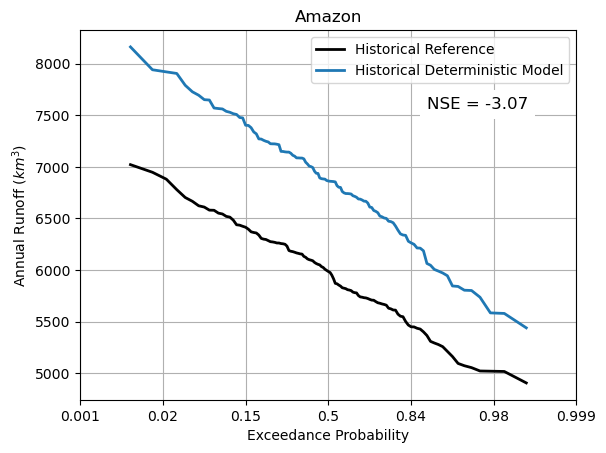

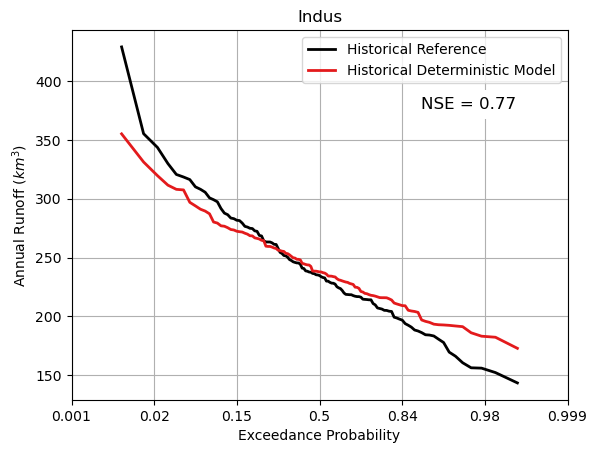

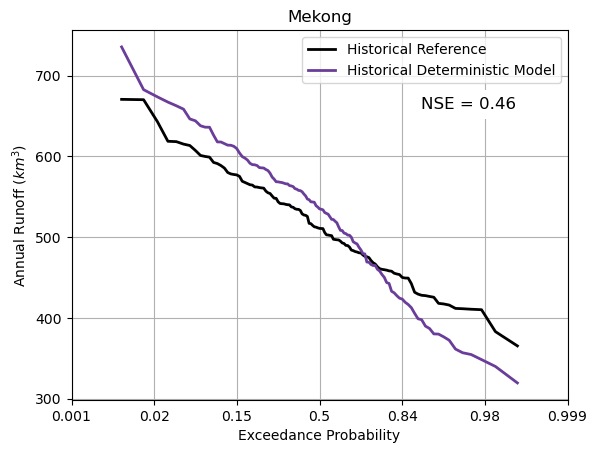

In [9]:
# plot flow duration curves for deterministic/observed:
for i in range(len(key_basins)): # loop through key basins

    #get basin runoff and ID
    df_basin = df[df.basin_name==key_basins[i]]
    df_basin_fut = df_fut[df_fut.basin_name==key_basins[i]]
    bsid = df_basin.basin_id.iloc[0] - 1
    
    # get associated NSE for that basin
    key_id = df_basin.basin_id.iloc[0]
    key_nse = nse_det[nse_det.basin_id==key_id]['nse_det'].iloc[0]

    #plot flow duration curve
    fig,ax = plt.subplots(1,1)
    plot_pexc(df_basin,Q_hist[:,bsid,:],df_basin_fut,Q_fut[:,bsid,:],clist[i],plot_type='hist_det',ax=ax) #plot
    ax.legend()
    ax.text(0.8,0.8,'NSE = '+str(round(key_nse,2)),bbox={'facecolor':'white', 'edgecolor':'none', 'pad':5},ha='center',va='center',transform=ax.transAxes,fontsize=12)

# Plots for Figure 3

Here, we look at model performance (bias, variance, correlation) for each basin across both deterministic model and 1,000-member stochastic ensemble

In [10]:
basin_nms = df['basin_name'].unique() #get list of basin names
basin_ids = df['basin_id'].unique()

#empty storage arrays
rho_det = np.zeros(nbasins)
delta_det = np.zeros(nbasins)
alpha_det = np.zeros(nbasins)
rho_stoch_median = np.zeros(nbasins)
delta_stoch_median = np.zeros(nbasins)
alpha_stoch_median = np.zeros(nbasins)

#for each basin
for j in range(nbasins):
    bsid = j+1
    df_basin = df[df.basin_id==bsid]
    bsnm = df_basin.basin_name.iloc[0]
    df_basin_stoch = Q_hist[:,bsid-1,:]

    #calculate bias, variance, correlation using mean, standard
    #deviation, rho, delta, alpha
    
    #observed
    mu_obs = np.mean(df_basin.q_obs)
    sig_obs = np.std(df_basin.q_obs)

    #deterministic
    mu_det = np.mean(df_basin.q_det)
    sig_det = np.std(df_basin.q_det)
    rho_det[j] = np.corrcoef(df_basin.q_obs,df_basin.q_det)[0,1]
    delta_det[j] = (mu_obs - mu_det)/mu_obs
    alpha_det[j] = sig_det/sig_obs

    #stochastic
    mu_stoch = np.mean(df_basin_stoch,axis=0)
    sig_stoch = np.std(df_basin_stoch,axis=0)
    rho_stoch = np.zeros(m)
    for i in range(m):
        rho_stoch[i] = np.corrcoef(df_basin.q_obs,df_basin_stoch[:,i])[0,1]
    delta_stoch= (mu_obs - mu_stoch)/mu_obs
    alpha_stoch = sig_stoch/sig_obs
    #median of stochastic
    rho_stoch_median[j] = np.median(rho_stoch)
    delta_stoch_median[j] = np.median(delta_stoch)
    alpha_stoch_median[j] = np.median(alpha_stoch)
    
#create data frame of mdoel statistics (rho, delta, alpha)
model_stats = pd.DataFrame()
model_stats['basin_nm'] = basin_nms
model_stats['basin_id'] = basin_ids
model_stats['rho_det'] = rho_det
model_stats['delta_det'] = delta_det
model_stats['alpha_det'] = alpha_det
model_stats['rho_stoch_median'] = rho_stoch_median
model_stats['delta_stoch_median'] = delta_stoch_median
model_stats['alpha_stoch_median'] = alpha_stoch_median
model_stats = gcam_basins.merge(model_stats,on=['basin_id'])


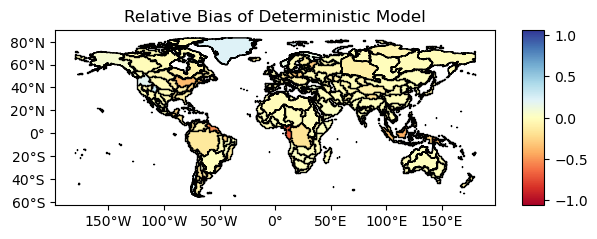

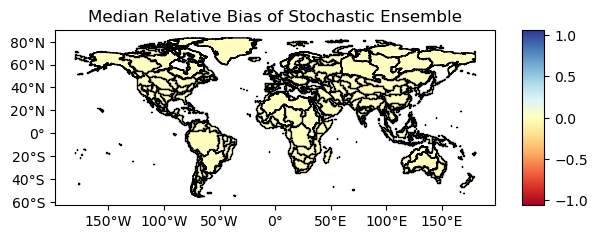

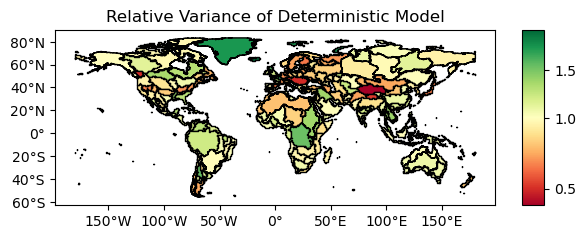

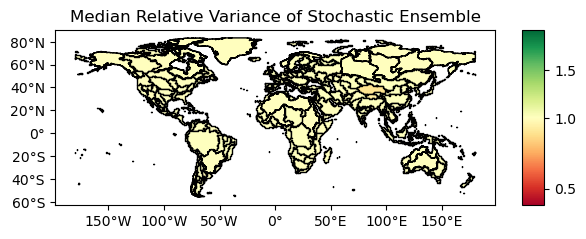

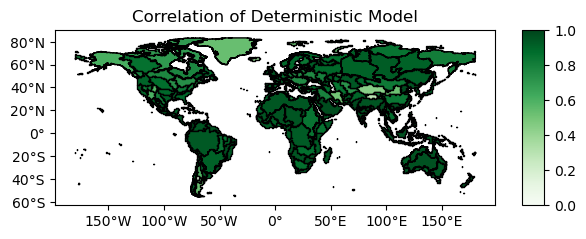

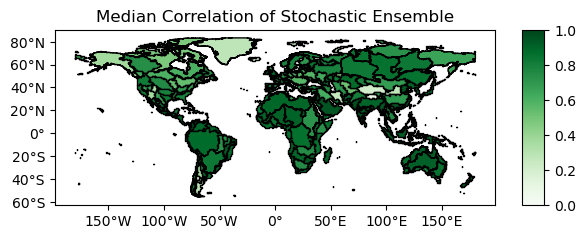

In [11]:
#define min and max vals for each set of maps

#min, max for bias
dmin = np.min([model_stats.delta_det.min(),model_stats.delta_stoch_median.min()])
dmax = np.max([model_stats.delta_det.max(),model_stats.delta_stoch_median.max()])
dval = np.max([np.abs(dmin),np.abs(dmax)])

#min, max for variance
amin = np.min([model_stats.alpha_det.min(),model_stats.alpha_stoch_median.min()])
amax = np.max([model_stats.alpha_det.max(),model_stats.alpha_stoch_median.max()])

#min, max for correlation
rmin = np.min([model_stats.rho_det.min(),model_stats.rho_stoch_median.min()])
rmax = np.max([model_stats.rho_det.max(),model_stats.rho_stoch_median.max()])
rmin = 0
rmax = 1

col_names = ['delta_det','delta_stoch_median','alpha_det','alpha_stoch_median','rho_det','rho_stoch_median']
vmins = [-dval,-dval,amin,amin,rmin,rmin] #maxs
vmaxs = [dval,dval,amax,amax,rmax,rmax] #mins
vcenters = [0,0,1,1,0.5,0.5] #centers
plt_titles = ['Relative Bias of Deterministic Model','Median Relative Bias of Stochastic Ensemble',
             'Relative Variance of Deterministic Model','Median Relative Variance of Stochastic Ensemble',
             'Correlation of Deterministic Model','Median Correlation of Stochastic Ensemble']
cmaps = ['RdYlBu','RdYlBu','RdYlGn','RdYlGn','Greens','Greens']

#loop through maps (columns)
for j in range(len(col_names)):
    col_name = col_names[j]
    fig,ax = plt.subplots(1,1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    model_stats.plot(ax=ax,cax=cax,column=col_name,legend=True,cmap=cmaps[j],
                norm = mcolors.TwoSlopeNorm(vmin=vmins[j],vmax=vmaxs[j],vcenter=vcenters[j]),edgecolor='k')
    axlbl = fig.axes[0]; ticksizes = axlbl.figure; cb_ax = ticksizes.axes[0];# cb_ax.tick_params(labelsize=14)
    cb_ax.set_xticks([-150,-100,-50,0,50,100,150]); cb_ax.set_yticks([-60,-40,-20,0,20,40,60,80])
    cb_ax.set_xticklabels(['150°W','100°W','50°W','0°','50°E','100°E','150°E'])
    cb_ax.set_yticklabels(['60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N'])
    cb_ax = ticksizes.axes[0]; #cb_ax.tick_params(labelsize=10);
    ax.set_title(plt_titles[j])
    plt.show()

# Plots for Figure 4

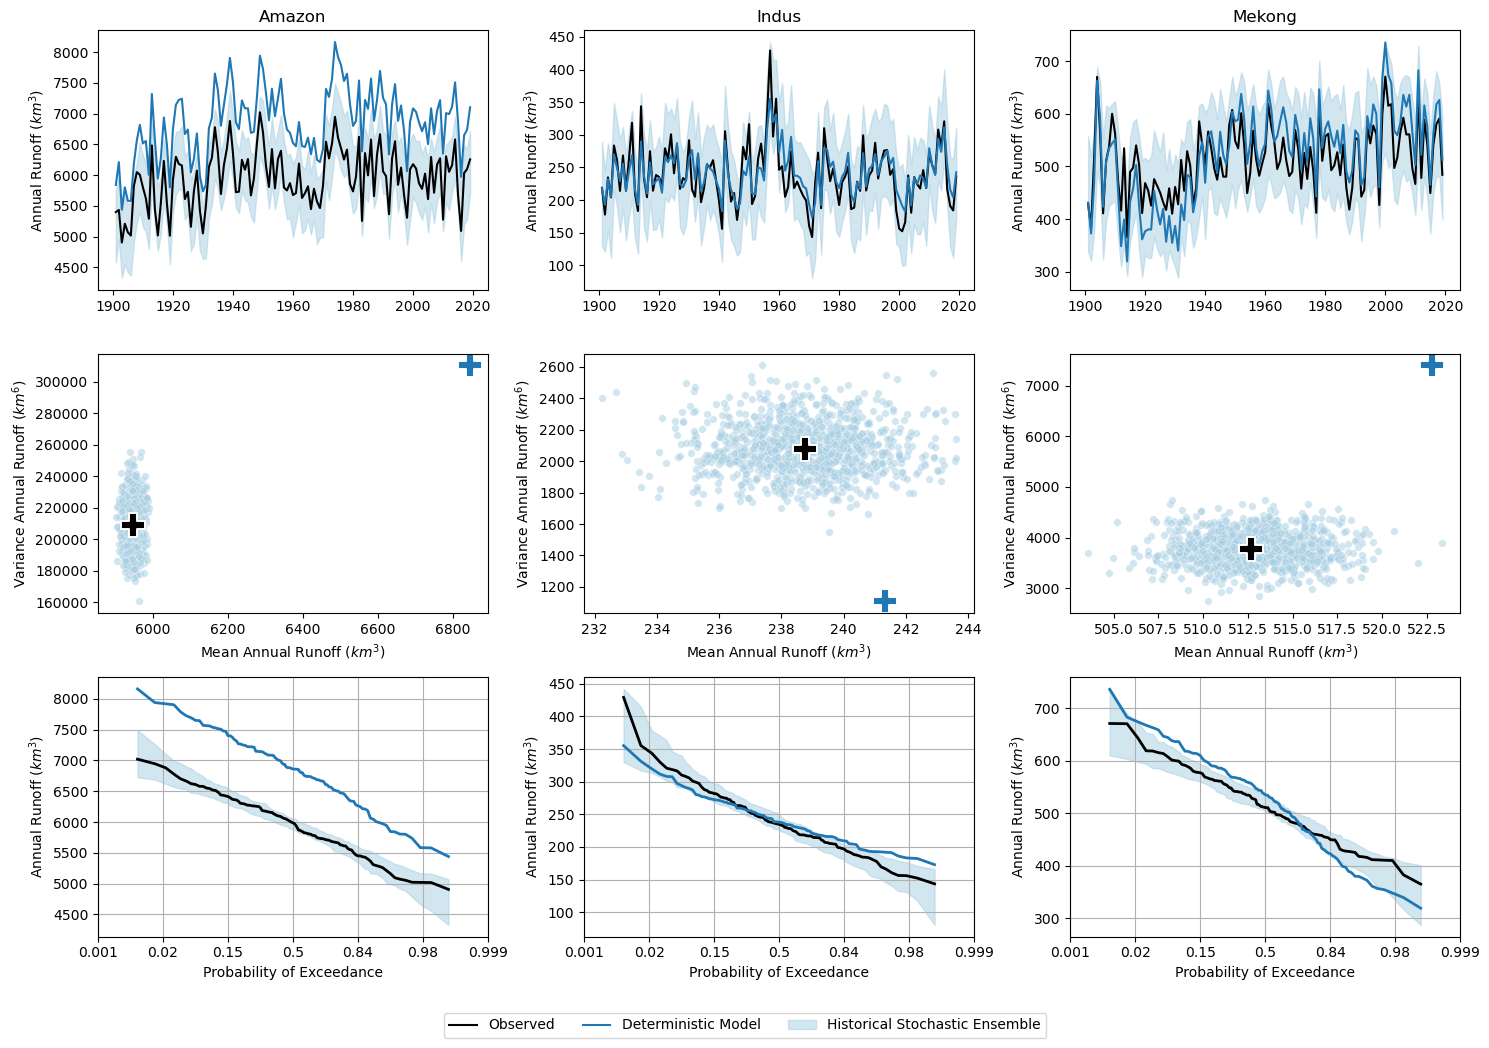

In [12]:
# results plots for a specific basin
fig,axes = plt.subplots(3,3,figsize=(15,10),gridspec_kw={'width_ratios': [1, 1,1]})
axes = axes.flatten()
bs_name_list = ['Amazon','Indus','Mekong']

#loop through basins
for i in range(len(bs_name_list)):
    bs_name = bs_name_list[i]
    bsid = df[df.basin_name==bs_name]['basin_id'].iloc[0] - 1
    df_basin = df[df.basin_name==bs_name] 
    df_basin_fut = df_fut[df_fut.basin_name==bs_name]

    boi_obs = q_ref[:,bsid] #observed
    boi_det = q_det[:,bsid] #deterministic
    boi_stoch = Q_hist[:,bsid,:] #stochastic
    boi_fdet = q_fut[:,bsid]#future
    boi_fstoch = Q_fut[:,bsid,:]#future stochastic

    # subplot 1: time series
    ax1 = axes[i]
    years = df.year.unique()[:]
    fyears = df_fut.year.unique()[:]
    sns.lineplot(ax=ax1,x=years,y=boi_obs,label='Observed',color='k',legend=True)
    sns.lineplot(ax=ax1,x=years,y=boi_det,label='Deterministic Model',color=cpal[1],legend=True)
    ax1.fill_between(years,np.min(boi_stoch,axis=1),np.max(boi_stoch,axis=1),color=cpal[0],alpha=0.5,label='Historical Stochastic Ensemble')
    ax1.set_ylabel('Annual Runoff ($km^3$)')
    ax1.tick_params(axis='both', which='major')
    ax1.set_title(bs_name)
    ax1.legend().set_visible(False)

    #second row is for scatterplots
    ax2 = axes[i+3]
    sns.scatterplot(ax=ax2,x=np.mean(boi_stoch,axis=0),y = np.var(boi_stoch,axis=0),s=30,label='Historical Stochastic Ensemble',color=cpal[0],alpha=0.5,legend=False)
    sns.scatterplot(ax=ax2,x=[np.mean(boi_obs)],y=[np.var(boi_obs)],s=300,label='Observed',color='k',legend=False,marker='P')
    sns.scatterplot(ax=ax2,x=[np.mean(boi_det)],y=[np.var(boi_det)],s=300,label='Historical Deterministic Model',color=cpal[1],legend=False,marker='P')
    ax2.set_xlabel('Mean Annual Runoff ($km^3$)')
    ax2.set_ylabel('Variance Annual Runoff ($km^6$)')
    ax2.tick_params(axis='both', which='major')
    
    #third row is for FDCs
    # subplot 3: probability of exceedance for future
    ax3 = axes[i+6]
    ax3 = plot_pexc(df_basin,Q_hist[:,bsid,:],df_basin_fut,Q_fut[:,bsid,:],cpal[1],cpal[0],'hist_stoch',ax=ax3,)
    ax3.set_xlabel('Probability of Exceedance')
    ax3.set_ylabel('Annual Runoff ($km^3$)')
    ax3.set_title('')
    ax3.tick_params(axis='both', which='major')
    ax3.legend().set_visible(False)
plt.tight_layout()
h, l = ax1.get_legend_handles_labels()
fig.legend(h[0:],l[0:],title='',loc='lower center',bbox_to_anchor=[0.5,-0.05],ncol=3)

# Plots for Figure 5

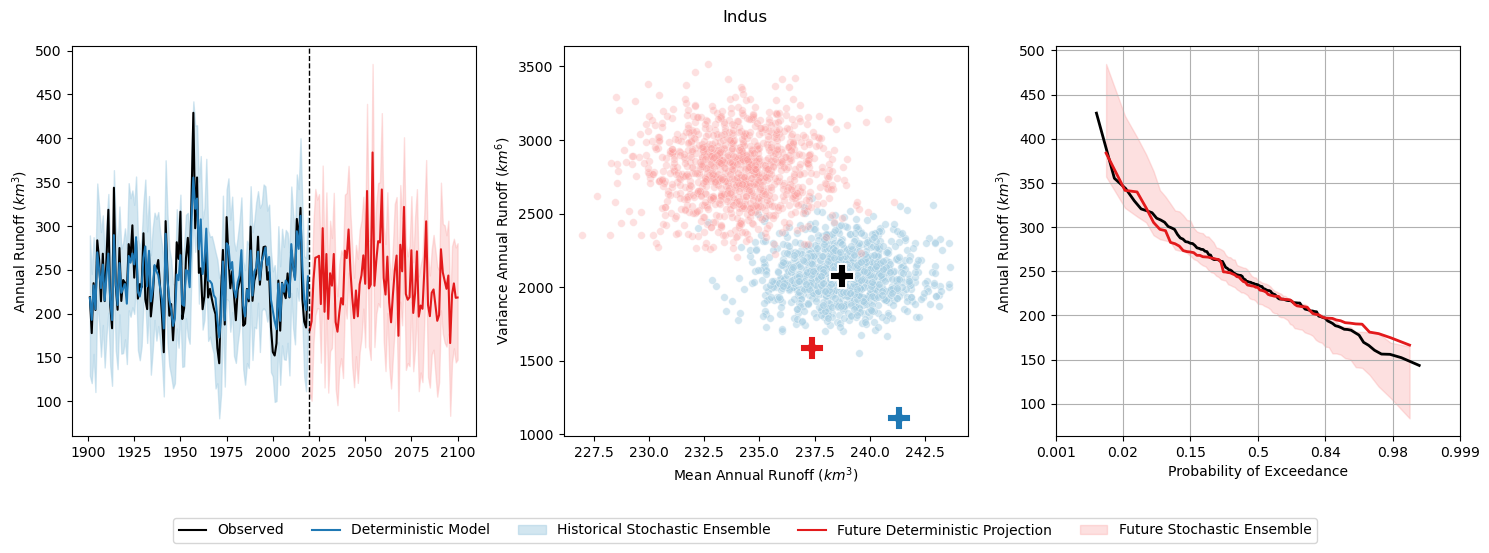

In [13]:
# results plots for a specific basin
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5),
                                 gridspec_kw={'width_ratios': [1, 1,1]})

bs_name = 'Indus'
bsid = df[df.basin_name==bs_name]['basin_id'].iloc[0] - 1

boi_obs = q_ref[:,bsid] #observed
boi_det = q_det[:,bsid] #deterministic
boi_stoch = Q_hist[:,bsid,:] #stochastic
boi_fdet = q_fut[:,bsid]#future
boi_fstoch = Q_fut[:,bsid,:]#future stochastic
df_basin = df[df.basin_name==bs_name] 
df_basin_fut = df_fut[df_fut.basin_name==bs_name]

# subplot 1: time series
years = df.year.unique()[:]
fyears = df_fut.year.unique()[:]
sns.lineplot(ax=ax1,x=years,y=boi_obs,label='Observed',color='k',legend=False)
sns.lineplot(ax=ax1,x=years,y=boi_det,label='Deterministic Model',color=cpal[1],legend=False)
ax1.fill_between(years,np.min(boi_stoch,axis=1),np.max(boi_stoch,axis=1),color=cpal[0],alpha=0.5,label='Historical Stochastic Ensemble')
sns.lineplot(ax=ax1,x=fyears,y=boi_fdet,label='Future Deterministic Projection',color=cpal[5],legend=False)
ax1.fill_between(fyears,np.min(boi_fstoch,axis=1),np.max(boi_fstoch,axis=1),color=cpal[4],alpha=0.3,label='Future Stochastic Ensemble')
ax1.axvline(years[-1]+0.5,color='k',lw=1,ls='--')
ax1.set_ylabel('Annual Runoff ($km^3$)')

# subplot 2: plot scatterplots of mean vs variance in annual runoff
sns.scatterplot(ax=ax2,x=np.mean(boi_stoch,axis=0),y = np.var(boi_stoch,axis=0),s=30,
                label='Historical Stochastic Ensemble',color=cpal[0],alpha=0.5,legend=False)
sns.scatterplot(ax=ax2,x=np.mean(boi_fstoch,axis=0),y = np.var(boi_fstoch,axis=0),s=30,
                label='Future Stochastic Ensemble',color=cpal[4],legend=False,alpha=0.3)
sns.scatterplot(ax=ax2,x=[np.mean(boi_obs)],y=[np.var(boi_obs)],s=300,label='Observed',color='k',legend=False,marker='P')
sns.scatterplot(ax=ax2,x=[np.mean(boi_det)],y=[np.var(boi_det)],s=300,label='Historical Deterministic Model',
                color=cpal[1],legend=False,marker='P')
sns.scatterplot(ax=ax2,x=[np.mean(boi_fdet)],y=[np.var(boi_fdet)],s=300,label='Future Deterministic Projection',
                color=cpal[5],legend=False,marker='P')
ax2.set_xlabel('Mean Annual Runoff ($km^3$)')
ax2.set_ylabel('Variance Annual Runoff ($km^6$)')

# subplot 3: probability of exceedance for future
ax3 = plot_pexc(df_basin,Q_hist[:,bsid,:],df_basin_fut,Q_fut[:,bsid,:],cpal[5],cpal[0],'fut_stoch',ax3)
ax3.set_xlabel('Probability of Exceedance')
ax3.set_ylabel('Annual Runoff ($km^3$)')
ax3.set_title('')
ax3.legend().set_visible(False)

plt.suptitle(bs_name)
plt.tight_layout()

h, l = ax1.get_legend_handles_labels()
fig.legend(h[0:],l[0:],title='',loc='lower center',bbox_to_anchor=[0.5,-0.1],ncol=5)

# Select scenarios to run through GCAM

To select scenarios to run through GCAM, we run the stochastic_error_model function for m=10,000. We then calculate cumulative runoff for 2070-2100 for the Indus basin and select 100 scenarios evenly spaced across the distribution. See supplement_figures.ipynb for code/figures related to this selection.

# Load in data for Figures 6-8.

We then run the 100 selected scenarios through GCAM. Replication instructions + code/data for the GCAM runs can be found on the GitHub repository for this paper. We query multiple quantities to explore the multisector impacts of variability in runoff, including water withdrawals, water price, max available runoff, land allocation by crop, crop production, primary energy consumption.

In [14]:
fpath = 'C:/Users/birnb/Documents/Tufts Research/GCIMS/birnbaum-etal_2024_HydroVariability/Data/' #path to data
 
#load in shapefile of GCAM basins and clean it up
bc_map = pd.read_csv(fpath+'Shapefiles_for_mapping/basin_to_country_mapping.csv')
gcam_basins = gcam_basins.rename(columns={'sbRgnAl':'GCAM_basin_ID'}) #rename columns
bc_map = bc_map.rename(columns={'GLU_name':'basin'}) #rename columns in basin-country mapping
gcam_basins = gcam_basins.merge(bc_map,on=['GCAM_basin_ID']) #merge basins with basin-country mapping

#load in shapefile of GCAM regions
gcam_regions = gpd.read_file(fpath+'Shapefiles_for_mapping/gcam_regions.shp')

#total water withdrawals
ww = pd.read_pickle(fpath+'GCAM_queries/ww')
#groundwater withdrawals
ww_gw = pd.read_pickle(fpath+'GCAM_queries/ww_gw')
#surface water withdrawals
ww_sw = pd.read_pickle(fpath+'GCAM_queries/ww_sw')
#max available runoff
mr = pd.read_pickle(fpath+'GCAM_queries/mr')
#water price
wp = pd.read_pickle(fpath+'GCAM_queries/wp')
#water withdrawals for irrigation
ww_irrig = pd.read_pickle(fpath+'GCAM_queries/ww_irrig')
# primary energy consumption
ep = pd.read_csv(fpath+'GCAM_queries/primary_energy.csv')
#ag production
agprod = pd.read_csv(fpath+'GCAM_queries/ag_production_allbasin_sum.csv')
#cropland allocation for Indus basin
la_indus = pd.read_csv(fpath+'GCAM_queries/land_alloc_indus.csv')

Next, "clean up" these datasets by limiting to years 2015-2100 and only crops of interest (when applicable)  

In [15]:
#list of crops to include for crop production
crop_list = ['CornC4', 'FiberCrop', 'FodderGrass', 'FodderHerbC4', 'FodderHerb',
       'FruitsTree', 'Fruits', 'Legumes', 'MiscCropTree', 'MiscCrop',
       'NutsSeedsTree', 'NutsSeeds', 'OilCropTree', 'OilCrop',
       'OtherGrainC4', 'OtherGrain', 'Rice', 'RootTuber', 'Soybean',
       'SugarCropC4', 'SugarCrop', 'Vegetables', 'Wheat'] #took out biomassGrass and biomassTree

#list of crops to include for land allocation
la_croplist = ['CornC4', 'FiberCrop', 'FodderGrass', 'FodderHerb',
       'FruitsTree', 'Fruits', 'Legumes', 'MiscCropTree',
       'MiscCrop', 'NutsSeedsTree', 'NutsSeeds', 'OilCropTree', 'OilCrop',
       'OilPalmTree', 'OtherGrainC4', 'OtherGrain', 'Rice',
       'RootTuber', 'Soybean',
       'SugarCropC4', 'Vegetables', 'Wheat', 'FodderHerbC4', 'SugarCrop']
#removed  'Grassland', 'OtherArableLand','Pasture','ProtectedGrassland','Protected Shrubland',
#'ProtectedUnmanagedPasture','RockIceDesert','Shrubland','UnmanagedPasture',Tundra','UrbanLand',
#'biomassGrass','Forest','ProtectedUnmanagedForest','UnmanagedForest','biomassTree'

#set water withdrawals for irrigation to crops of interest and year >= 2015
ww_irrig = ww_irrig[(ww_irrig.crop.isin(crop_list)) & (ww_irrig.year>=2015)]

#set year>= 2015 for runoff, total water withdrawals, and surface water withdrawals 
mr = mr[(mr.year>=2015)]
ww = ww[(ww.year>=2015)]
sw = ww_sw[(ww_sw.year>=2015)]

#create variables for global water withdrawals, primary energy, and ag production
ww_glob = ww.groupby(['scenario','Units','year'])['value'].sum().reset_index() #global water withdrawals
ep_glob = ep.groupby(['scenario','Units','year'])['value'].sum().reset_index() #primary energy
ep_glob = ep_glob[ep_glob.year>=2015] #limit to 2015 and later
agprod_glob = agprod.groupby(['scenario','Units','year'])['value'].sum().reset_index() #ag production
agprod_glob = agprod_glob[agprod_glob.year>=2015] #limit to 2015 and later

# Plots for Figure 6

Figure 6A shows time series from 2015-2100 of coefficient of variation in each of primary energy consumption, total water withdrawals, and crop production (globally). 

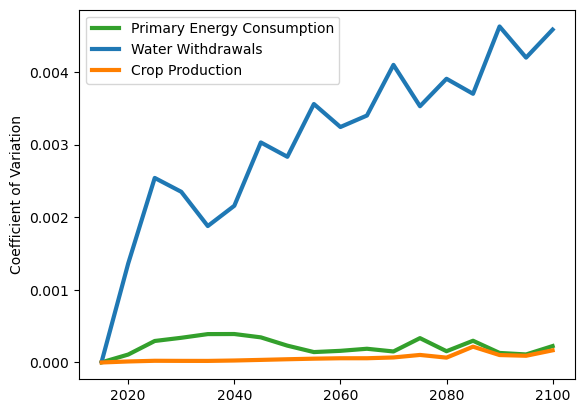

In [16]:
#CV for global energy consumption
cv_ep_glob = ep_glob.groupby(['year'])['value'].std()/ep_glob.groupby(['year'])['value'].mean()
cv_ep_glob = cv_ep_glob.reset_index()

#CV for global total water withdrawals
cv_ww_glob = ww_glob.groupby(['year'])['value'].std()/ww_glob.groupby(['year'])['value'].mean()
cv_ww_glob = cv_ww_glob.reset_index()

#CV for global total ag production
cv_agprod_glob = agprod_glob.groupby(['year'])['value'].std()/agprod_glob.groupby(['year'])['value'].mean()
cv_agprod_glob = cv_agprod_glob.reset_index()

fig = plt.figure() #create figure
sns.lineplot(data=cv_ep_glob,x='year',y='value',label='Primary Energy Consumption',color=cpal[3],lw=3)
sns.lineplot(data=cv_ww_glob,x='year',y='value',label='Water Withdrawals',color=cpal[1],lw=3)
sns.lineplot(data=cv_agprod_glob,x='year',y='value',label='Crop Production',color=cpal[7],lw=3)
plt.xlabel('')
plt.ylabel('Coefficient of Variation')
plt.show()

Figure 6B shows map of basin variability in 2100 for crop production

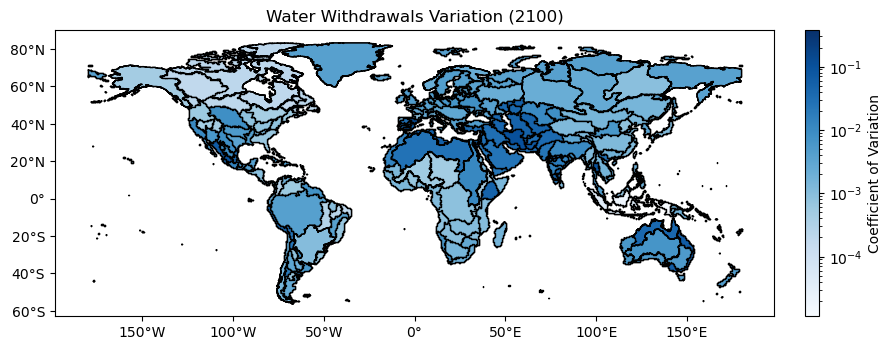

In [17]:
#create variable of total water withdrawals in 2100
ww_2100 = ww.groupby(['scenario','Units','basin','year'])['value'].sum().reset_index()
ww_2100 = ww_2100[ww_2100.year==2100]

#calculate variability for each basin
cv_ww_2100 = ww_2100.groupby(['basin','year'])['value'].std()/ww_2100.groupby(['basin','year'])['value'].mean()
cv_ww_2100 = cv_ww_2100.reset_index()
cv_ww_2100 = gcam_basins.merge(cv_ww_2100,on=['basin'])

fig,ax = plt.subplots(1,1,figsize=(10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.2)

gcam_basins.plot(edgecolor='k',ax=ax,facecolor='None')
cv_ww_2100.plot(ax=ax,cax=cax,column='value',cmap='Blues',edgecolor='k',
                norm=mcolors.LogNorm(vmin=cv_ww_2100.value.min(), vmax=cv_ww_2100.value.max()),
                   legend=True,legend_kwds={'orientation':'vertical','label':'Coefficient of Variation'})
ax.set_title('Water Withdrawals Variation (2100)')


# #making latitude/longitude text labels smaller
 #label maps with lat/lon coordinates
axlbl = fig.axes[0] #https://gist.github.com/sebbacon/60ceec549f1d461af4543ccc5024c095?short_path=839cef5
ticksizes = axlbl.figure
cb_ax = ticksizes.axes[0]
cb_ax.tick_params()

cb_ax.set_xticks([-150,-100,-50,0,50,100,150])
cb_ax.set_yticks([-60,-40,-20,0,20,40,60,80])
cb_ax.set_xticklabels(['150°W','100°W','50°W','0°','50°E','100°E','150°E'])
cb_ax.set_yticklabels(['60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N'])

plt.show()

Figure 6C shows map of regional variability in 2100 for primary energy consumption

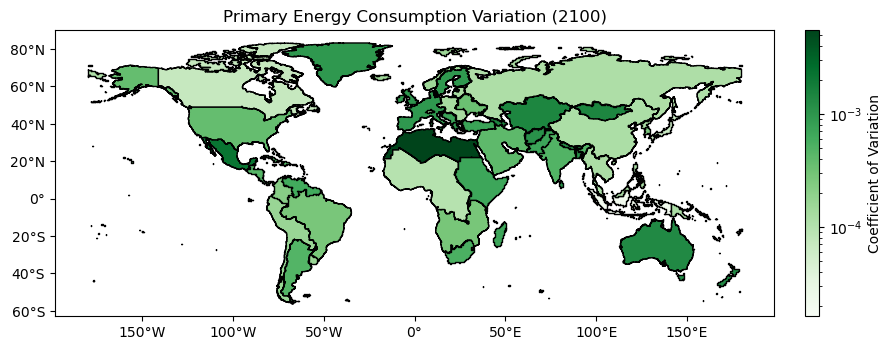

In [18]:
#first create ep_2100 variable that is regional energy consumption in 2100 (all sources summed)
ep_2100 = ep.groupby(['scenario','Units','region','year'])['value'].sum().reset_index()
ep_2100 = ep_2100[ep_2100.year==2100]

#calculate CV in 2100 for each region
cv_ep_2100 = ep_2100.groupby(['region','year'])['value'].std()/ep_2100.groupby(['region','year'])['value'].mean()
cv_ep_2100 = cv_ep_2100.reset_index()

#rename EU_12 and EU_15 regions to match map shapefile
cv_ep_2100.loc[cv_ep_2100.region=='EU-12','region'] = 'EU_12'
cv_ep_2100.loc[cv_ep_2100.region=='EU-15','region'] = 'EU_15'

#merge with gcam_regions shapefile for mapping
cv_ep_2100 = gcam_regions.merge(cv_ep_2100,on=['region'])

fig,ax = plt.subplots(1,1,figsize=(10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.2)

cv_ep_2100.plot(ax=ax,cax=cax,column='value',cmap='Greens',edgecolor='k',
                norm=mcolors.LogNorm(vmin=cv_ep_2100.value.min(), vmax=cv_ep_2100.value.max()),
               legend=True,legend_kwds={'orientation':'vertical',
                                       'label':'Coefficient of Variation'})
ax.set_title('Primary Energy Consumption Variation (2100)')

# #making latitude/longitude text labels smaller
 #label maps with lat/lon coordinates
axlbl = fig.axes[0] #https://gist.github.com/sebbacon/60ceec549f1d461af4543ccc5024c095?short_path=839cef5
ticksizes = axlbl.figure
cb_ax = ticksizes.axes[0]
cb_ax.tick_params()

cb_ax.set_xticks([-150,-100,-50,0,50,100,150])
cb_ax.set_yticks([-60,-40,-20,0,20,40,60,80])
cb_ax.set_xticklabels(['150°W','100°W','50°W','0°','50°E','100°E','150°E'])
cb_ax.set_yticklabels(['60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N'])

plt.show()

Figure 6D shows map of basin variability in 2100 for crop production

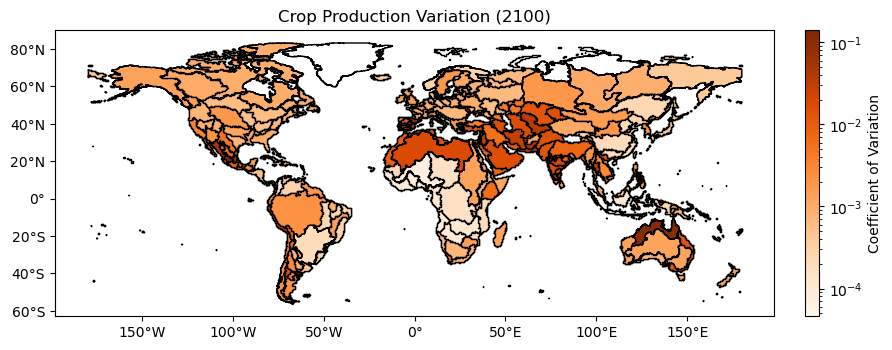

In [19]:
#create variable of basin-level crop production in 2100
agprod_2100 = agprod.groupby(['scenario','Units','basin','year'])['value'].sum().reset_index()
agprod_2100 = agprod_2100[agprod_2100.year==2100]

#calculate CV for each basin
cv_agprod_2100 = agprod_2100.groupby(['basin','year'])['value'].std()/agprod_2100.groupby(['basin','year'])['value'].mean()
cv_agprod_2100 = cv_agprod_2100.reset_index()
cv_agprod_2100 = gcam_basins.merge(cv_agprod_2100,on=['basin'])

fig,ax = plt.subplots(1,1,figsize=(10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.2)

gcam_basins.plot(edgecolor='k',ax=ax,facecolor='None')

cv_agprod_2100.plot(ax=ax,cax=cax,column='value',cmap='Oranges',edgecolor='k',
                    norm=mcolors.LogNorm(vmin=cv_agprod_2100.value.min(), vmax=cv_agprod_2100.value.max()),
                   legend=True,legend_kwds={'orientation':'vertical','label':'Coefficient of Variation'})
ax.set_title('Crop Production Variation (2100)')

# #making latitude/longitude text labels smaller
 #label maps with lat/lon coordinates
axlbl = fig.axes[0] #https://gist.github.com/sebbacon/60ceec549f1d461af4543ccc5024c095?short_path=839cef5
ticksizes = axlbl.figure
cb_ax = ticksizes.axes[0]
cb_ax.tick_params()

cb_ax.set_xticks([-150,-100,-50,0,50,100,150])
cb_ax.set_yticks([-60,-40,-20,0,20,40,60,80])
cb_ax.set_xticklabels(['150°W','100°W','50°W','0°','50°E','100°E','150°E'])
cb_ax.set_yticklabels(['60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N'])

plt.show()

# Plots for Figure 7

Begin by calculating coefficient of variations for relevant quantities

In [20]:
#CV for total water withdrawals (by basin)
cv_ww_basin = ww.groupby(['year','basin'])['value'].std()/ww.groupby(['year','basin'])['value'].mean()
cv_ww_basin = cv_ww_basin.reset_index()

#CV for runoff (by basin)
cv_mr_basin = mr.groupby(['year','basin'])['value'].std()/mr.groupby(['year','basin'])['value'].mean()
cv_mr_basin = cv_mr_basin.reset_index()

#CV for surface water withdrawals (by basin)
cv_sw_basin = sw.groupby(['year','basin'])['value'].std()/sw.groupby(['year','basin'])['value'].mean()
cv_sw_basin = cv_sw_basin.reset_index()
cv_sw_basin = cv_sw_basin.rename(columns={'value':'value_sw'})

#merge CV for total water withdrawals, runoff, and surface water withdrawals
cv_basin = cv_ww_basin.merge(cv_mr_basin,on=['year','basin'],suffixes=['_ww','_mr'])
cv_basin = cv_basin.merge(cv_sw_basin,on=['year','basin'])
cv_basin = cv_basin.filter(['year','basin','value_ww','value_mr','value_sw']) #filter to columns of interest

#create relative variability ratios, defined as CV quantity divided by CV runoff
cv_basin['ww_mr'] = cv_basin['value_ww']/cv_basin['value_mr'] #create column for ratio of total water withdrawals to runoff
cv_basin['sw_mr'] = cv_basin['value_sw']/cv_basin['value_mr'] #create column for ratio of surface water withdrawals to runoff


Figure 7A is map of CV total water withdrawals divided by CV runoff in 2100

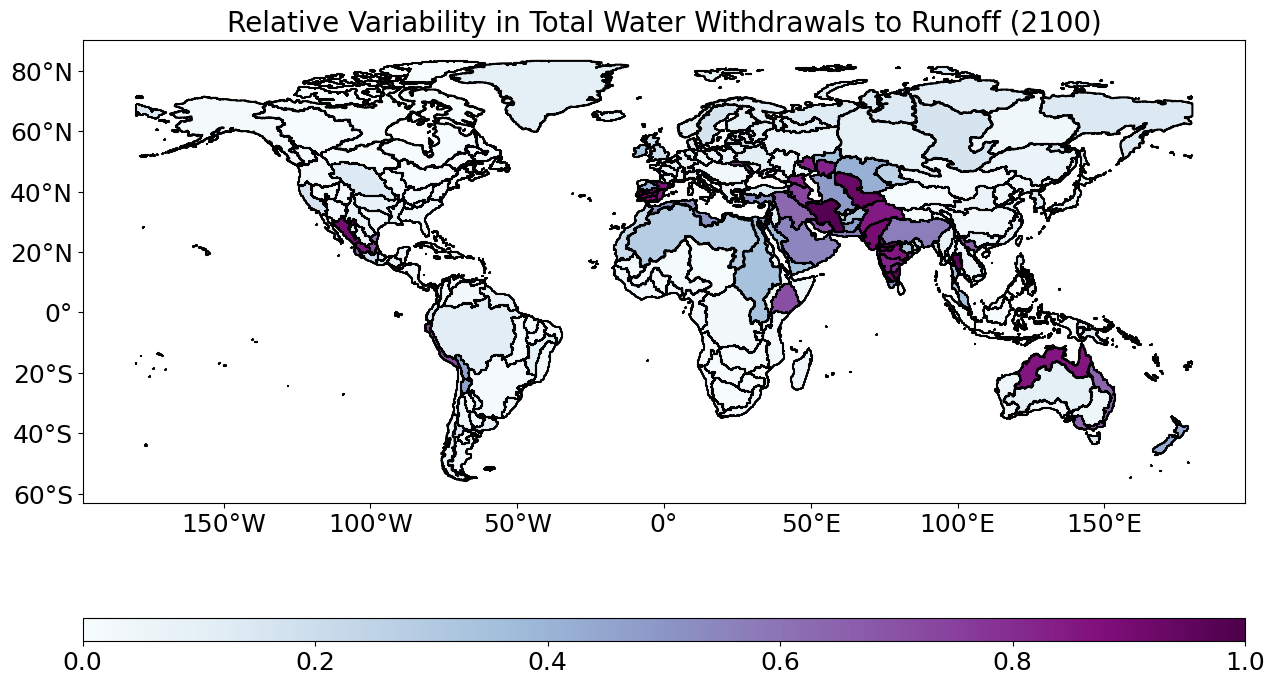

In [21]:
fig,(ax0) = plt.subplots(1,1,figsize=(15,10))

plot_df = cv_basin[cv_basin.year==2100] #limit to year 2100
plot_df = gcam_basins.merge(plot_df,on=['basin'])
plot_df.boundary.plot(ax=ax0,edgecolor='k')
plot_df.plot(column='ww_mr',ax=ax0,vmin=0,vmax=1,cmap='BuPu',legend=True,
            legend_kwds={'orientation':'horizontal','aspect':50})
             
# #making latitude/longitude text labels smaller
axlbl = fig.axes[0]
ticksizes = axlbl.figure
cb_ax = ticksizes.axes[0]
cb_ax.tick_params(labelsize=14)
 #label maps with lat/lon coordinates
cb_ax.set_xticks([-150,-100,-50,0,50,100,150])
cb_ax.set_yticks([-60,-40,-20,0,20,40,60,80])
cb_ax.set_xticklabels(['150°W','100°W','50°W','0°','50°E','100°E','150°E'])
cb_ax.set_yticklabels(['60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N'])
cb_ax = ticksizes.axes[0]
cb_ax.tick_params(labelsize=18)
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=18)

ax0.set_title('Relative Variability in Total Water Withdrawals to Runoff (2100)',fontsize=20)
plt.show()

Figure 7B is map of CV surface water withdrawals divided by CV runoff in 2100

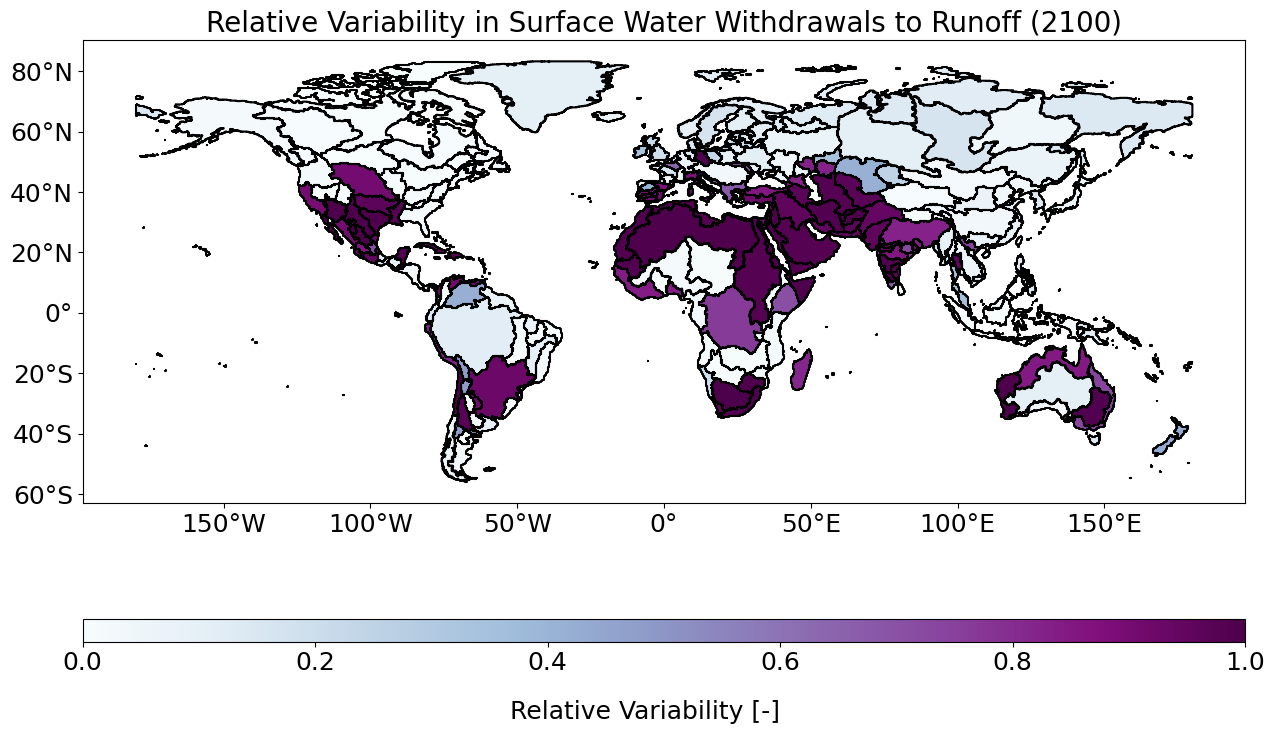

In [22]:
fig,(ax0) = plt.subplots(1,1,figsize=(15,10))

plot_df = cv_basin[cv_basin.year==2100] #limit to year 2100
plot_df = gcam_basins.merge(plot_df,on=['basin'])
plot_df.boundary.plot(ax=ax0,edgecolor='k')
plot_df.plot(column='sw_mr',ax=ax0,vmin=0,vmax=1,cmap='BuPu',legend=True,
            legend_kwds={'orientation':'horizontal','aspect':50})
             
# #making latitude/longitude text labels smaller
axlbl = fig.axes[0]
ticksizes = axlbl.figure
cb_ax = ticksizes.axes[0]
cb_ax.tick_params(labelsize=14)
 #label maps with lat/lon coordinates
cb_ax.set_xticks([-150,-100,-50,0,50,100,150])
cb_ax.set_yticks([-60,-40,-20,0,20,40,60,80])
cb_ax.set_xticklabels(['150°W','100°W','50°W','0°','50°E','100°E','150°E'])
cb_ax.set_yticklabels(['60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N'])
cb_ax = ticksizes.axes[0]
cb_ax.tick_params(labelsize=18)
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=18)
fig.text(0.5,0.125,'Relative Variability [-]',fontsize=18,ha='center')
ax0.set_title('Relative Variability in Surface Water Withdrawals to Runoff (2100)',fontsize=20)
plt.show()

Print out the 10 basins with the highest relative variability ratios for total water withdrawals/runoff

In [23]:
cv_basin[cv_basin.year==2100].sort_values(by='ww_mr',ascending=False).head(10)

,year,basin,value_ww,value_mr,value_sw,ww_mr,sw_mr
4044,2100,Iran,0.105648,0.108071,0.106585,0.977581,0.986249
4136,2100,SinaiP,0.379033,0.392994,0.350611,0.964476,0.892154
4039,2100,IndCstE,0.032456,0.033850,0.032456,0.958801,0.958801
3991,2100,ChaoPhrR,0.087929,0.092200,0.087929,0.953679,0.953679
4001,2100,DeadSea,0.138922,0.148536,0.138922,0.935279,0.935279
3957,2100,AmuDaryaR,0.049363,0.052900,0.051053,0.933147,0.965092
4148,2100,TaptiR,0.022109,0.023795,0.022109,0.929142,0.929142
4074,2100,MexCstNW,0.067041,0.074257,0.067037,0.902828,0.902774
4083,2100,NarmadaR,0.023606,0.026148,0.023606,0.902788,0.902788
3990,2100,CauveryR,0.048697,0.054087,0.052864,0.900341,0.977395


# Plots for Figure 8

In [24]:
ww_irrig_indus = ww_irrig[ww_irrig.basin=='IndusR'] #water withdrawals for irrigation
mr_indus = mr[(mr.basin=='IndusR')] #runoff
ww_sw_indus = ww_sw[(ww_sw.year>=2015) & (ww_sw.basin=='IndusR')] #surface water withdrawals
ww_indus = ww[(ww.year>=2015) & (ww.basin=='IndusR')] #total water withdrawals
wp_indus = wp[(wp.basin=='IndusR') & (wp.year>=2015)] #water price

# sum up irrigation water withdrawals across crop types
ww_irrig_indus_sum = ww_irrig_indus.groupby(['scenario','Units','year','basin'])['value'].sum().reset_index()

#clean up cropland allocation
la_indus = la_indus[la_indus.year>=2015] #limit to year>=2015
la_indus[['crop','basin','irr_type','fert_type']] = la_indus.landleaf.str.split('_',n=3,expand=True) 
la_indus = la_indus[(la_indus.crop.isin(la_croplist))] #limit to crops of interest
la_indus_sum = la_indus.groupby(['scenario','Units','year','irr_type'])['value'].sum().reset_index() #sum all crops
la_indus_irrig = la_indus_sum[la_indus_sum.irr_type=='IRR'] #sum irrigated crops
la_indus_rfd = la_indus_sum[la_indus_sum.irr_type=='RFD'] #sum rainfed crops

years = mr_indus.year.unique() #get years

Figure 8A is a time series 2015-2100 of relative variability in quantities of interest (surface water withdrawals, irrigated cropland, water price, water withdrawals for irrigation) to runoff for Indus basin

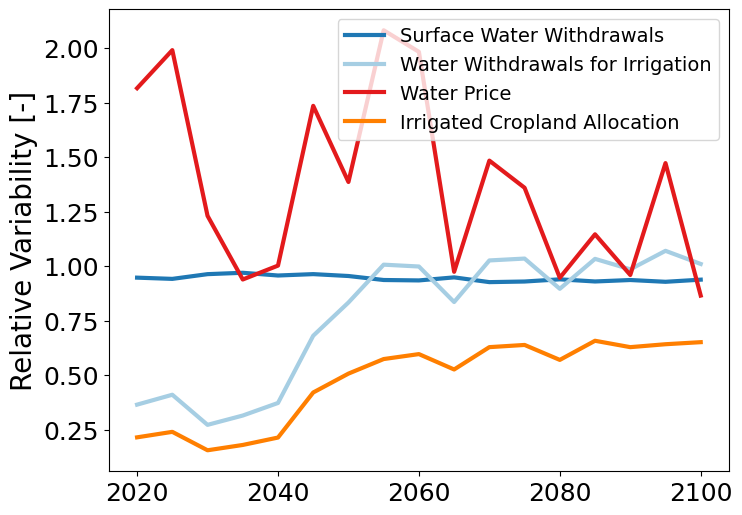

In [25]:
#calculate coefficient of variation for each quantity
cv_mr_indus = mr_indus.groupby(['year'])['value'].std()/mr_indus.groupby(['year'])['value'].mean() #runoff
cv_mr_indus = cv_mr_indus.reset_index()

cv_wp_indus = wp_indus.groupby(['year'])['value'].std()/wp_indus.groupby(['year'])['value'].mean() #water price
cv_wp_indus = cv_wp_indus.reset_index()

cv_sw_indus = ww_sw_indus.groupby(['year'])['value'].std()/ww_sw_indus.groupby(['year'])['value'].mean() #surface water withdrawals
cv_sw_indus = cv_sw_indus.reset_index()

cv_ww_irrig_indus = ww_irrig_indus_sum.groupby(['year'])['value'].std()/ww_irrig_indus_sum.groupby(['year'])['value'].mean() #irrigation water withdrawals
cv_ww_irrig_indus = cv_ww_irrig_indus.reset_index()

cv_la_irrig_indus = la_indus_irrig.groupby(['year'])['value'].std()/la_indus_irrig.groupby(['year'])['value'].mean() #irrigated cropland
cv_la_irrig_indus = cv_la_irrig_indus.reset_index()

#merge all CVs together
cv_indus1 = cv_wp_indus.merge(cv_sw_indus,on=['year'],suffixes=['_wp','_sw'])
cv_indus2 = cv_la_irrig_indus.merge(cv_ww_irrig_indus,on=['year'],suffixes=['_la_irrig','_ww_irrig'])
cv_indus = cv_indus1.merge(cv_indus2)
cv_indus = cv_indus.merge(cv_mr_indus,on=['year'])
cv_indus = cv_indus.rename(columns={'value':'value_mr'})
cv_indus = cv_indus[cv_indus.year>=2020] #limit to year 2020 and later

#get ratios of CV quantity to CV runoff
cv_indus_ratios = cv_indus.copy()
cv_indus_ratios['value_wp'] = cv_indus_ratios['value_wp']/cv_indus_ratios['value_mr']
cv_indus_ratios['value_ww_irrig'] = cv_indus_ratios['value_ww_irrig']/cv_indus_ratios['value_mr']
cv_indus_ratios['value_la_irrig'] = cv_indus_ratios['value_la_irrig']/cv_indus_ratios['value_mr']
cv_indus_ratios['value_sw'] = cv_indus_ratios['value_sw']/cv_indus_ratios['value_mr']

#plot CV ratios
fig,ax2 = plt.subplots(1,1,figsize=(8,6))
sns.lineplot(data=cv_indus_ratios,x='year',y='value_sw',color=cpal[1],lw=3,ax=ax2,label='Surface Water Withdrawals')
sns.lineplot(data=cv_indus_ratios,x='year',y='value_ww_irrig',color=cpal[0],lw=3,ax=ax2,label='Water Withdrawals for Irrigation')
sns.lineplot(data=cv_indus_ratios,x='year',y='value_wp',color=cpal[5],lw=3,ax=ax2,label='Water Price')
sns.lineplot(data=cv_indus_ratios,x='year',y='value_la_irrig',color=cpal[7],lw=3,ax=ax2,label='Irrigated Cropland Allocation')
ax2.set_xlabel('')
ax2.set_ylabel('Relative Variability [-]',fontsize=20)
#ax2.set_title('Indus')
ax2.legend([],[],frameon=False)
ax2.legend(loc='best',frameon=True,fontsize=14)
#plt.suptitle('Indus Basin')
plt.tick_params(axis='both', which='major', labelsize=18)
#ax2.legend(ncol=2,loc='lower center',fontsize=14,framealpha=1)
plt.show()

Figure 8B shows time series of runoff 2015-2100 for Indus basin, median, low runoff, and high runoff scenarios are highlighted

Lowest Runoff in 2100


scenario    stochastic_runoff_random_1
Units                             km^3
year                              2100
value                           176.03
basin                           IndusR
Name: 2199, dtype: object

------------------------------
Highest Runoff in 2100


scenario    stochastic_runoff_random_37
Units                              km^3
year                               2100
value                           221.063
basin                            IndusR
Name: 160423, dtype: object

------------------------------
Median Runoff in 2100


scenario    stochastic_runoff_random_52
Units                              km^3
year                               2100
value                           202.806
basin                            IndusR
Name: 247191, dtype: object

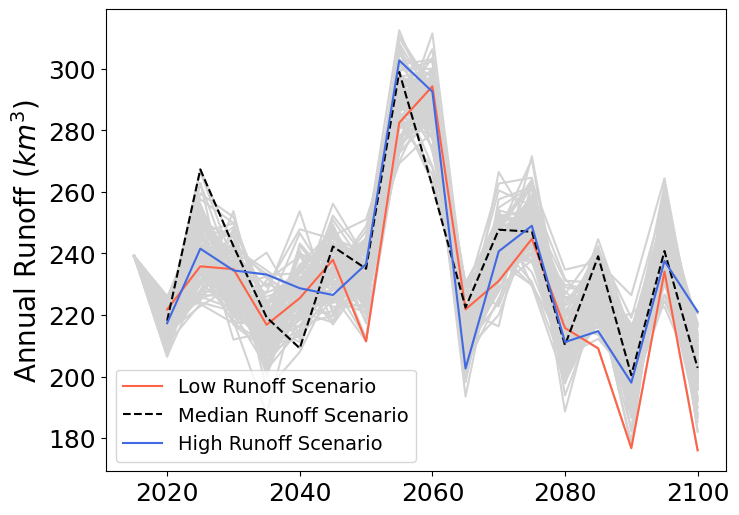

In [26]:
#begin by identifying which scenarios are the lowest, highest, and median

#lowest
print('Lowest Runoff in 2100')
display(mr_indus[mr_indus.year==2100].sort_values(by='value',ascending=True).iloc[0])
print('------------------------------')
#highest
print('Highest Runoff in 2100')
display(mr_indus[mr_indus.year==2100].sort_values(by='value',ascending=False).iloc[0])
print('------------------------------')
#median
print('Median Runoff in 2100')
display(mr_indus[mr_indus.year==2100].sort_values(by='value',ascending=False).iloc[49])

#plot
fig,axi = plt.subplots(1,1,figsize=(8,6))
years = mr_indus.year.unique()

sns.lineplot(data=mr_indus,x='year',y='value',color='lightgray',estimator=None,units='scenario')
sns.lineplot(data=mr_indus[(mr_indus.scenario=='stochastic_runoff_random_1') &
                          (mr_indus.year>=2020)],
            x='year',y='value',label='Low Runoff Scenario',color='tomato')
sns.lineplot(data=mr_indus[(mr_indus.scenario=='stochastic_runoff_random_52') &
                          (mr_indus.year>=2020)],
            x='year',y='value',label='Median Runoff Scenario',color='k',ls='--')
sns.lineplot(data=mr_indus[(mr_indus.scenario=='stochastic_runoff_random_37') &
                          (mr_indus.year>=2020)],
            x='year',y='value',label='High Runoff Scenario',color='royalblue')

axi.set_xlabel('')
axi.set_ylabel('Annual Runoff ($km^3$)',fontsize=20)
axi.legend([],[],frameon=False)
axi.legend(loc='lower left',frameon=True,fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

Figures 8C and 8D show maps of percent change in irrigated cropland in 2100 between the highest/lowest runoff scenarios and the median scenario

In [27]:
yr = 2100 #indicate which year we want to make these plots for

#load in CSV data of land allocation in these three scenarios (all basins)
fpath = 'C:/Users/birnb/Documents/Tufts Research/GCIMS/birnbaum-etal_2024_HydroVariability/Data/'
la_worst = pd.read_csv(fpath+'GCAM_queries/land_alloc_1.csv')
la_best = pd.read_csv(fpath+'GCAM_queries/land_alloc_32.csv')
la_median = pd.read_csv(fpath+'GCAM_queries/land_alloc_49.csv')

#"clean up" data
la_crop = pd.concat([la_median,la_worst,la_best]) #merge the three scenarios
la_crop[['crop','basin','irr_type','fert_type']] = la_crop.landleaf.str.split('_',n=3,expand=True)
#select crops, year, and irrigated only
la_crop = la_crop[(la_crop.crop.isin(la_croplist)) & (la_crop.year==yr) & (la_crop.irr_type=='IRR')]
#sum across crops
la_crop_sum = la_crop.groupby(['Units','scenario','year','basin','irr_type'])['value'].sum().reset_index()

#calculate absolute difference between scenarios and median
la_crop_median = la_crop_sum[la_crop_sum.scenario=='stochastic_runoff_random_52']
la_crop_sum = la_crop_median.merge(la_crop_sum,on=['Units','year','basin','irr_type'],suffixes=['_median','_scenario'])
la_crop_sum['value_diff'] = la_crop_sum['value_scenario'] - la_crop_sum['value_median']
#calculate percent difference between scenarios and median
la_crop_sum['pct_diff'] = 100*((la_crop_sum['value_scenario'] - la_crop_sum['value_median'])/la_crop_sum['value_median'])

Make Figure 8C, difference between high runoff scenario and median

-44.97, -15.00 --> -15+
-15.00, -10.00 --> -15 to -10
-10.00,  -5.00 --> -10 to -5
 -5.00,   0.00 --> -5 to 0
  0.00,   5.00 --> 0 to 5
  5.00,  10.00 --> 5 to 10
 10.00,  15.00 --> 10 to 15
 15.00, 927.06 --> 15+


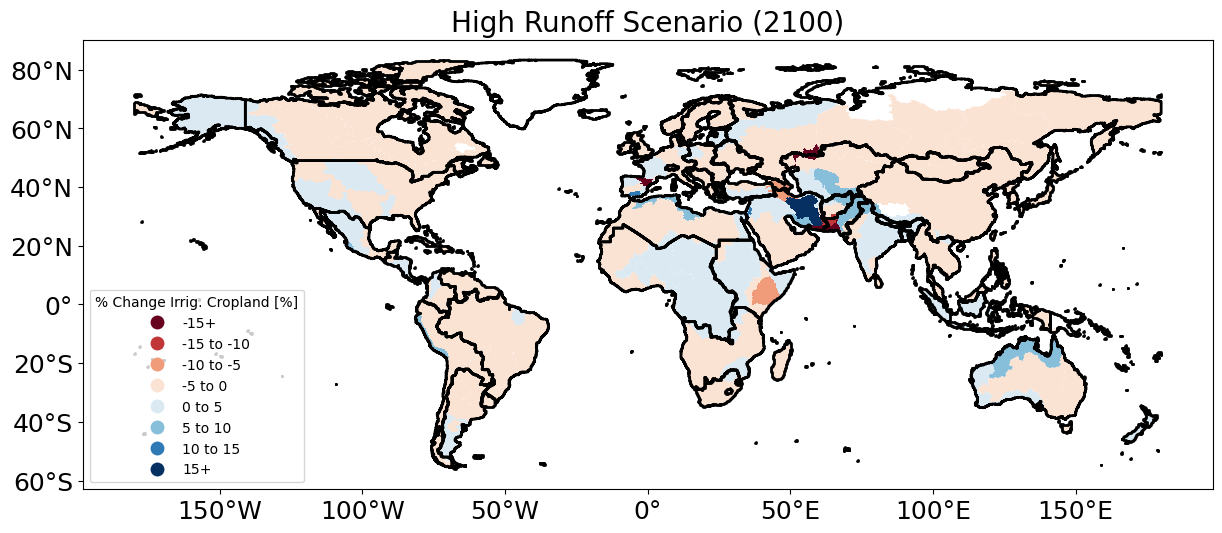

In [29]:
fig8c = la_crop_sum[(la_crop_sum.scenario_scenario=='stochastic_runoff_random_37')]
fig8c = gcam_basins.merge(fig8c,on=['basin'])

fig,(ax) = plt.subplots(1,1,figsize=(15,10))
divider = make_axes_locatable(ax)
fig8c.plot(column='pct_diff',ax=ax,cmap='RdBu',legend=True,scheme='user_defined',
             classification_kwds={'bins':[-15,-10,-5,0,5,10,15]},legend_kwds={'loc':'lower left','title':'Percent Difference'})
gcam_regions.boundary.plot(ax=ax,edgecolor='k',lw=2)

#make legend (https://stackoverflow.com/questions/74143732/customize-legend-labels-in-geopandas)
leg1 = ax.get_legend()
leg1.set_title('% Change Irrig. Cropland [%]')
new_legtxt = ['-15+','-15 to -10','-10 to -5','-5 to 0','0 to 5','5 to 10','10 to 15','15+'] 
for ix,eb in enumerate(leg1.get_texts()):
    print(eb.get_text(), "-->", new_legtxt[ix])
    eb.set_text(new_legtxt[ix])
    
#making latitude/longitude text labels smaller
#label maps with lat/lon coordinates
#https://gist.github.com/sebbacon/60ceec549f1d461af4543ccc5024c095?short_path=839cef5
axlbl = fig.axes[0]
ticksizes = axlbl.figure
cb_ax = ticksizes.axes[0]
cb_ax.tick_params()
cb_ax.set_xticks([-150,-100,-50,0,50,100,150])
cb_ax.set_yticks([-60,-40,-20,0,20,40,60,80])
cb_ax.set_xticklabels(['150°W','100°W','50°W','0°','50°E','100°E','150°E'])
cb_ax.set_yticklabels(['60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N'])
cb_ax.tick_params(labelsize=18)

ax.set_title('High Runoff Scenario ('+str(yr)+')',fontsize=20)
plt.show()

Make Figure 8D, difference between low runoff scenario and median

  -inf, -15.00 --> -15+
-15.00, -10.00 --> -15 to -10
-10.00,  -5.00 --> -10 to -5
 -5.00,   0.00 --> -5 to 0
  0.00,   5.00 --> 0 to 5
  5.00,  10.00 --> 5 to 10
 10.00,  15.00 --> 10 to 15
 15.00,  66.86 --> 15+


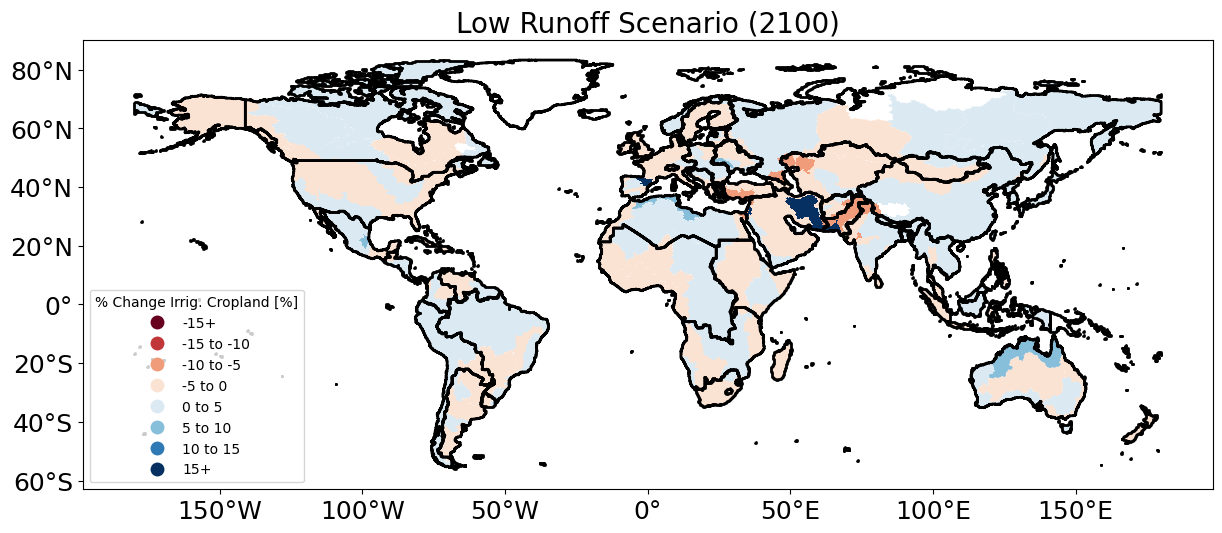

In [31]:
fig8d = la_crop_sum[(la_crop_sum.scenario_scenario=='stochastic_runoff_random_1')]
fig8d = gcam_basins.merge(fig8d,on=['basin'])
fig8d.loc[fig8d.pct_diff==-np.inf,'pct_diff'] = np.nan

fig,(ax) = plt.subplots(1,1,figsize=(15,10))
divider = make_axes_locatable(ax)
fig8d.plot(column='pct_diff',ax=ax,cmap='RdBu',legend=True,
                          scheme='user_defined',classification_kwds={'bins':[-15,-10,-5,0,5,10,15]},
            legend_kwds={'loc':'lower left'})
gcam_regions.boundary.plot(ax=ax,edgecolor='k',lw=2)

leg1 = ax.get_legend()
leg1.set_title('% Change Irrig. Cropland [%]')
new_legtxt = ['-15+','-15 to -10','-10 to -5','-5 to 0','0 to 5','5 to 10','10 to 15','15+'] 
for ix,eb in enumerate(leg1.get_texts()):
    print(eb.get_text(), "-->", new_legtxt[ix])
    eb.set_text(new_legtxt[ix])

#making latitude/longitude text labels smaller
#label maps with lat/lon coordinates
#https://gist.github.com/sebbacon/60ceec549f1d461af4543ccc5024c095?short_path=839cef5
axlbl = fig.axes[0]
ticksizes = axlbl.figure
cb_ax = ticksizes.axes[0]
cb_ax.tick_params()
cb_ax.set_xticks([-150,-100,-50,0,50,100,150])
cb_ax.set_yticks([-60,-40,-20,0,20,40,60,80])
cb_ax.set_xticklabels(['150°W','100°W','50°W','0°','50°E','100°E','150°E'])
cb_ax.set_yticklabels(['60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N'])
cb_ax.tick_params(labelsize=18)

ax.set_title('Low Runoff Scenario ('+str(yr)+')',fontsize=20)
plt.show()